# Multimodal Unsupervised Learning (Before Dimensionality Reduction)

## Setup

In [1]:
import os
from glob import glob
from pathlib import Path
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import sklearn as sk
import pickle
import copy
import time

### Paths

In [2]:
input_path = '../../../2.data_preparation/out/fusion/'
output_path = '../out/before_dim_red/'
# Global configuration path
glob_conf_path = '../../../config/global_config.py'

### Load gloabal variables

In [3]:
exec(open(glob_conf_path).read())

### Load data

In [4]:
multi_df = pd.read_csv(input_path + 'audio_video_dataset_unsupervised_learning.csv')
#multi_df['emotion'] = multi_df['emotion_id'].map(emotion_id_to_emotion)
#multi_df = multi_df.drop(columns=['emotion_id'])

In [5]:
multi_df.head()

,F0semitoneFrom27.5Hz_sma3nz_amean,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_percentile20.0,F0semitoneFrom27.5Hz_sma3nz_percentile50.0,F0semitoneFrom27.5Hz_sma3nz_percentile80.0,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,...,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r,emotion_id
0,0.579782,0.276111,0.533631,0.596311,0.632179,0.209500,0.178389,0.032262,0.261604,0.070276,...,0.391106,0.112723,0.033404,0.133362,0.016468,0.019319,0.394809,0.123362,0.024128,amu
1,0.393945,0.343674,0.384970,0.423466,0.446001,0.147274,0.282919,0.175538,0.267522,0.068505,...,0.292710,0.074774,0.029097,0.082065,0.028774,0.016000,0.246774,0.110516,0.023097,amu
2,0.487920,0.288303,0.466380,0.452395,0.584362,0.226165,0.321936,0.164298,0.311106,0.203101,...,0.457659,0.221317,0.024927,0.105854,0.022000,0.055171,0.179024,0.128976,0.015366,amu
3,0.415525,0.320765,0.357067,0.355146,0.490685,0.233617,0.187911,0.038932,0.222829,0.040867,...,0.298545,0.180061,0.031030,0.073758,0.022121,0.034182,0.153212,0.168485,0.009576,amu
4,0.578382,0.277224,0.455800,0.559710,0.627945,0.291699,0.210346,0.112102,0.258617,0.044221,...,0.353421,0.246211,0.010053,0.095368,0.011947,0.047632,0.182842,0.058526,0.019526,amu


## Determining the number of clusters

In order to determine the number of clusters we will use the following techniques:
* CH index [1]
* Average silhouette value

[1] Calinski and Harabasz (1974), “A dendrite method for cluster analysis”

### K-Means Clustering

#### CH index

In [8]:
from sklearn.cluster import KMeans

def calculateBCSS(X, km):
    _, label_counts = np.unique(km.labels_, return_counts = True)
    diff_cluster_sq = np.linalg.norm(km.cluster_centers_ - np.mean(X,axis=0).values, axis=1)**2
    return sum(label_counts * diff_cluster_sq)


X = multi_df.drop(columns=['emotion_id'])
y = multi_df.emotion_id.values

# Initialize variables
results = []
K_max = 100
K = range(2,K_max)
for k in tqdm(K):
    km = KMeans(n_clusters=k, n_init=100, n_jobs=-1, random_state=seed)
    km = km.fit(X)
    WCSS_k = km.inertia_
    BCSS_k = calculateBCSS(X,km)
    CH_k = (BCSS_k/WCSS_k)*((len(X)-k)/(k-1))
    results.append([k,WCSS_k,BCSS_k,CH_k])

results_df = pd.DataFrame(results, columns=['k','WCSS','BCSS','CH_index'])
results_df.to_csv(os.path.join(output_path,'results','ch_kmeans_before_dim_red.csv'), index=None, header=True)

100%|██████████| 98/98 [08:19<00:00,  5.09s/it]


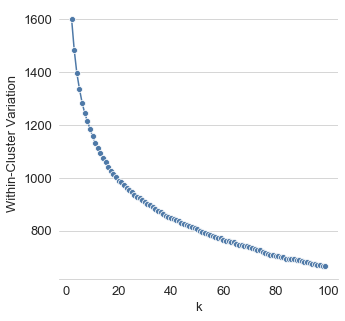

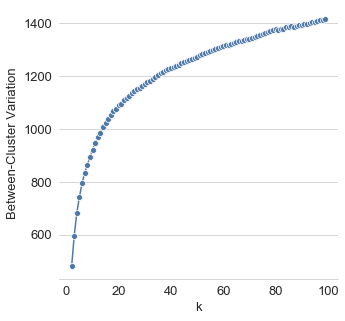

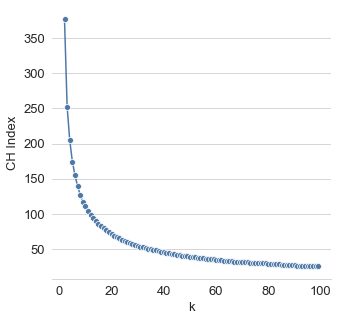

In [11]:
results_df = pd.read_csv(os.path.join(output_path,'results','ch_kmeans_before_dim_red.csv'))

plt.figure(figsize=[5,5])
sns.lineplot('k', 'WCSS', marker='o', data=results_df, color=blue_rgb)
plt.xlabel('k')
plt.ylabel('Within-Cluster Variation')
plt.grid(axis='x')
plt.savefig(os.path.join(output_path,'charts','ch_wcss_kmeans_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

plt.figure(figsize=[5,5])
sns.lineplot('k', 'BCSS', marker='o', data=results_df, color=blue_rgb)
plt.xlabel('k')
plt.ylabel('Between-Cluster Variation')
plt.grid(axis='x')
plt.savefig(os.path.join(output_path,'charts','ch_bcss_kmeans_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

plt.figure(figsize=[5,5])
sns.lineplot('k', 'CH_index', marker='o', data=results_df, color=blue_rgb)
plt.xlabel('k')
plt.ylabel('CH Index')
plt.grid(axis='x')
plt.savefig(os.path.join(output_path,'charts','report_ch_kmeans_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

#### Average Silhouette Value

In [12]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score


X = multi_df.drop(columns=['emotion_id'])
y = multi_df.emotion_id.values

# Initialize variables
results = []          
K_max = 100
K = range(2,K_max)
for k in tqdm(K):
    km = KMeans(n_clusters=k, n_init=100, n_jobs=-1, random_state=seed)
    cluster_labels = km.fit_predict(X)
    silhouette_avg_k = silhouette_score(X, cluster_labels)
    results.append([k,silhouette_avg_k])
results_df = pd.DataFrame(results,columns=['k','silhouette_avg'])
results_df.to_csv(os.path.join(output_path,'results','silhouette_kmeans_before_dim_red.csv'), index=None, header=True)

100%|██████████| 98/98 [08:15<00:00,  5.05s/it]


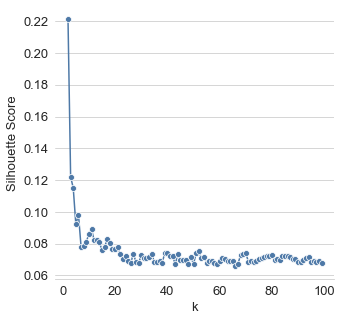

In [8]:
results_df = pd.read_csv(os.path.join(output_path,'results','silhouette_kmeans_before_dim_red.csv'))

plt.figure(figsize=(5,5))
sns.lineplot(x='k', y='silhouette_avg', marker='o', data=results_df, color=blue_rgb)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.grid(axis='x')
plt.savefig(os.path.join(output_path,'charts','report_silhouette_kmeans_before_dim_red.svg'), bbox_inches = 'tight')

The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar. Therefore, once again, 2 is the best number of clusters.

### Result

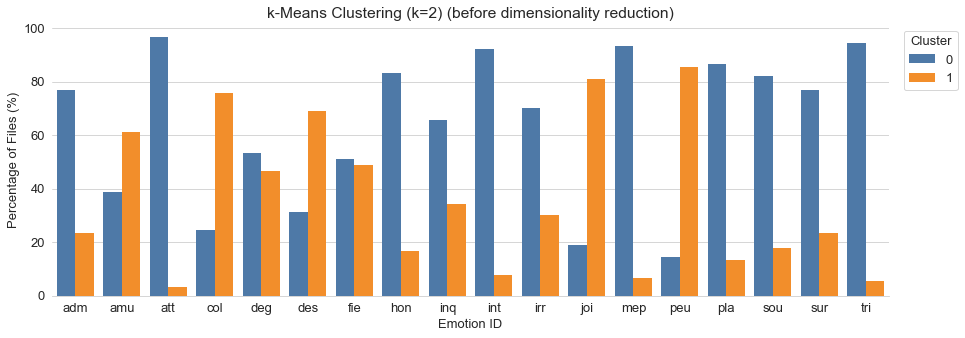

In [31]:
from sklearn.cluster import KMeans

X = multi_df.drop(columns=['emotion_id'])
y = multi_df.emotion_id.values
km = KMeans(n_clusters=2, n_init=100, n_jobs=-1, random_state=seed)
labels = km.fit_predict(X)
tmp_df = multi_df.copy()

tmp_df['cluster'] = labels
tmp_df.head()
emotion_cluster = tmp_df.groupby(['emotion_id','cluster']).agg({'F0semitoneFrom27.5Hz_sma3nz_amean':'count'}).rename(columns={'F0semitoneFrom27.5Hz_sma3nz_amean':'counts'})
perc_df = emotion_cluster.groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index().rename(columns={'counts':'percentage'})

plt.figure(figsize=[15,5])
sns.barplot(x='emotion_id', y='percentage', hue='cluster', data=perc_df, saturation=sns_saturation, palette=palette_def)
plt.xlabel('Emotion ID')
plt.ylabel('Percentage of Files (%)')
plt.legend(title='Cluster', loc='upper right', bbox_to_anchor=(1.09, 1))
plt.savefig(os.path.join(output_path,'charts','report_k_kmeans_k_2_before_dim_red.svg'), bbox_inches = 'tight')
plt.title('k-Means Clustering (k=2) (before dimensionality reduction)')
plt.savefig(os.path.join(output_path,'charts','k_kmeans_k_2_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

# Feature importances via Decision Tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import train_test_split


df = tmp_df.copy()                                                                     # tmp_df contains the multimodal feature dat
X = df.drop(columns=['emotion_id','cluster'])
y = df.cluster

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=seed)

# MODEL INTERPRETATION VIA DECISION TREE -------------------------------------------------------------------------------------------------------------------------------------------------------------
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X,y)

dot_data = export_graphviz(clf,
                           out_file = os.path.join(output_path,'others','report_tree_kmeans_k_2_before_dim_red.dot'),
                           feature_names = X.columns,
                           filled = False,
                           class_names = ['0','1'],
                           max_depth = 3)  
! dot -Nfontname=Sans-Serif -Efontname=Sans-Serif -Tsvg ../out/before_dim_red/others/report_tree_kmeans_k_2_before_dim_red.dot -o ../out/before_dim_red/others/report_tree_kmeans_k_2_before_dim_red.svg
! dot -Nfontname=Sans-Serif -Efontname=Sans-Serif -Tpng ../out/before_dim_red/others/report_tree_kmeans_k_2_before_dim_red.dot -o ../out/before_dim_red/others/report_tree_kmeans_k_2_before_dim_red.png 

In [19]:
df_tmp = emotion_cluster.reset_index()
idx = df_tmp.groupby(['emotion_id'])['counts'].transform(max) == df_tmp['counts']
df_tmp[idx]

,emotion_id,cluster,counts
0,adm,0,23
3,amu,1,55
4,att,0,29
7,col,1,68
8,deg,0,16
11,des,1,62
12,fie,0,46
14,hon,0,25
16,inq,0,59
18,int,0,82


### Hierarchical Clustering

#### CH index

In [20]:
from scipy.cluster.hierarchy import linkage, cut_tree

def getCentroids(X,clusters,labels):
    X_tmp = X.copy()
    X_tmp['cluster'] = clusters    
    #centroids = {l: X_tmp.loc[X_tmp['cluster'] == l].mean().values for l in labels}
    centroids = [X_tmp.drop(columns='cluster').loc[X_tmp['cluster'] == l].mean().values for l in labels]
    return centroids

def calculateWCSS(X, clusters):
    labels, label_counts = np.unique(clusters, return_counts = True)
    X_tmp = X.copy()
    X_tmp['cluster'] = clusters
    centroids = getCentroids(X,clusters,labels)
    diff_cluster_sq = [np.linalg.norm(X_tmp.drop(columns='cluster').loc[X_tmp['cluster'] == l] - centroids[l])**2 for l in labels]
    return sum(diff_cluster_sq)

def calculateBCSS(X, clusters):
    labels, label_counts = np.unique(clusters, return_counts = True)
    diff_cluster_sq = np.linalg.norm(getCentroids(X,clusters,labels) - np.mean(X,axis=0).values, axis=1)**2
    return sum(label_counts * diff_cluster_sq)


X = multi_df.drop(columns=['emotion_id'])
y = multi_df.emotion_id.values

K_max = 100
K = range(2,K_max)
method_values = ['single','complete','weighted']
results = []
for method in tqdm(method_values):
    links = linkage(X, method=method, metric='cityblock')
    
    for k in K:
        clusters = cut_tree(links, n_clusters=k)
        WCSS_k = calculateWCSS(X,clusters)
        BCSS_k = calculateBCSS(X,clusters)
        CH_k = (BCSS_k/WCSS_k)*((len(X)-k)/(k-1))
        results.append([method,
                        k,
                        WCSS_k,
                        BCSS_k,
                        CH_k]
                      )
results_df = pd.DataFrame(results,columns=['method','k','WCSS','BCSS','CH_index'])
results_df.to_csv(os.path.join(output_path,'results','ch_hier_clust_before_dim_red.csv'), index=None, header=True)

100%|██████████| 3/3 [10:08<00:00, 202.69s/it]


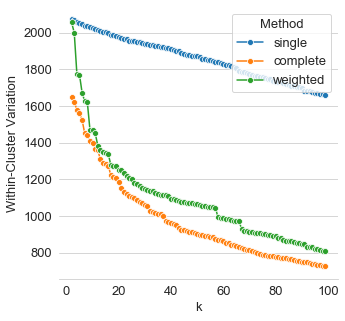

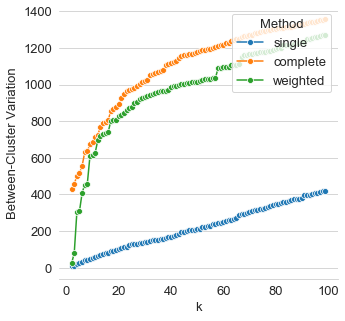

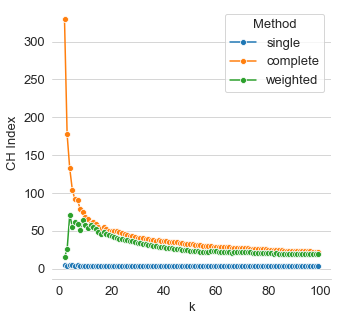

In [10]:
results_df = pd.read_csv(os.path.join(output_path,'results','ch_hier_clust_before_dim_red.csv'))

plt.figure(figsize=[5,5])
sns.lineplot(x='k', y='WCSS', marker='o', hue='method', data=results_df, color=palette_def)
plt.xlabel('k')
plt.ylabel('Within-Cluster Variation')
plt.grid(axis='x')
plt.legend(labels=results_df['method'].unique(), title='Method', loc='upper right')
plt.savefig(os.path.join(output_path,'charts','ch_wcss_hier_clust_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

plt.figure(figsize=[5,5])
sns.lineplot(x='k', y='BCSS', marker='o', hue='method', data=results_df, color=palette_def)
plt.xlabel('k')
plt.ylabel('Between-Cluster Variation')
plt.grid(axis='x')
plt.legend(labels=results_df['method'].unique(), title='Method', loc='upper right')
plt.savefig(os.path.join(output_path,'charts','ch_bcss_hier_clust_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

plt.figure(figsize=[5,5])
sns.lineplot(x='k', y='CH_index', marker='o', hue='method', data=results_df, color=palette_def)
plt.xlabel('k')
plt.ylabel('CH Index')
plt.grid(axis='x')
plt.legend(labels=results_df['method'].unique(), title='Method', loc='upper right')
plt.savefig(os.path.join(output_path,'charts','report_ch_hier_clust_before_dim_red.svg'), bbox_inches = 'tight')
plt.show()

In [22]:
results_df = pd.read_csv(os.path.join(output_path,'results','ch_hier_clust_before_dim_red.csv'))
results_df.loc[results_df.groupby('method')['CH_index'].idxmax()]

,method,k,WCSS,BCSS,CH_index
98,complete,2,1648.121595,431.951814,329.443794
0,single,2,2072.868908,7.204501,4.368852
198,weighted,4,1777.233309,302.840100,71.283893


#### Average Silhouette Value

In [23]:
from scipy.cluster.hierarchy import linkage, cut_tree
from sklearn.metrics import silhouette_score


X = multi_df.drop(columns=['emotion_id'])
y = multi_df.emotion_id.values


# Initialize variables
K_max = 100
K = range(2,K_max)
method_values = ['single','complete','weighted']
results = []
for method in tqdm(method_values):
    links = linkage(X, method=method, metric='cityblock')

    #for k in tqdm(K):
    for k in K:
        cluster_labels = cut_tree(links, n_clusters=k)
        silhouette_avg_k = silhouette_score(X, cluster_labels.ravel(), metric='cityblock')
        results.append([method,k,silhouette_avg_k])

results_df = pd.DataFrame(results, columns=['method', 'k', 'silhouette_avg'])
results_df.to_csv(os.path.join(output_path,'results','silhouette_hier_clust_before_dim_red.csv'), index=None, header=True)

100%|██████████| 3/3 [02:47<00:00, 55.99s/it] 


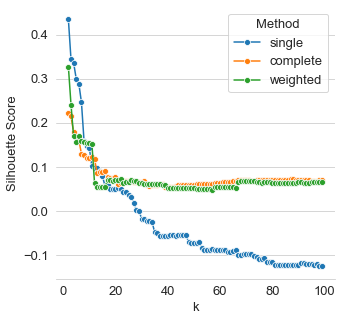

In [9]:
results_df = pd.read_csv(os.path.join(output_path,'results','silhouette_hier_clust_before_dim_red.csv'))

plt.figure(figsize=[5,5])
sns.lineplot(x='k', y='silhouette_avg', marker='o', hue='method', data=results_df, color=palette_def)
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.grid(axis='x')
plt.legend(labels=results_df['method'].unique(), title='Method', loc='upper right')
plt.savefig(os.path.join(output_path,'charts','report_silhouette_hier_clust_before_dim_red.svg'), bbox_inches = 'tight')

In [25]:
results_df = pd.read_csv(os.path.join(output_path,'results','silhouette_hier_clust_before_dim_red.csv'))
results_df.loc[results_df.groupby('method')['silhouette_avg'].idxmax()]

,method,k,silhouette_avg
98,complete,2,0.222478
0,single,2,0.434546
196,weighted,2,0.327136


## Hierarchical clustering (before dimensionality reduction)

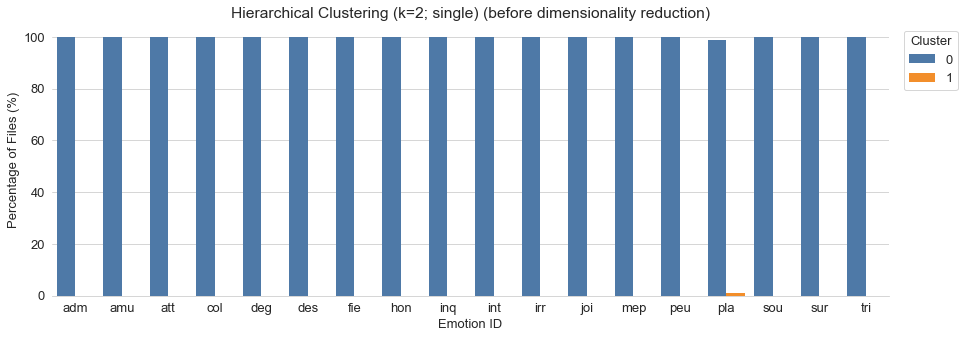

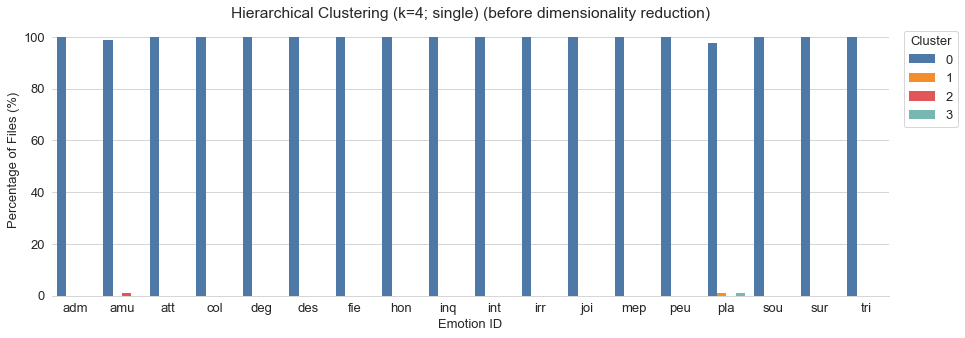

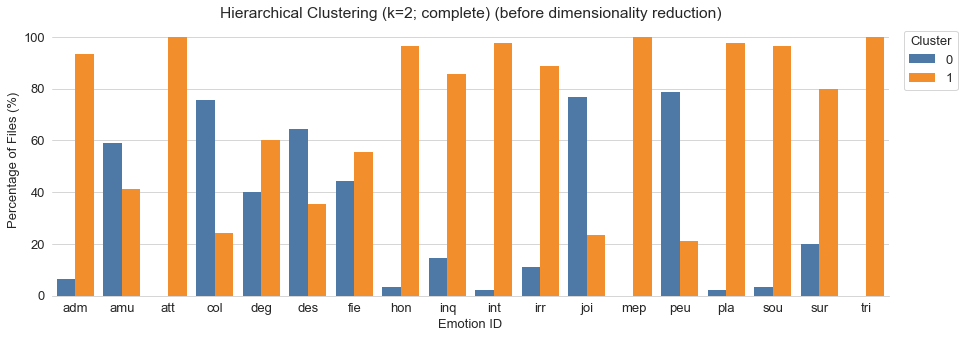

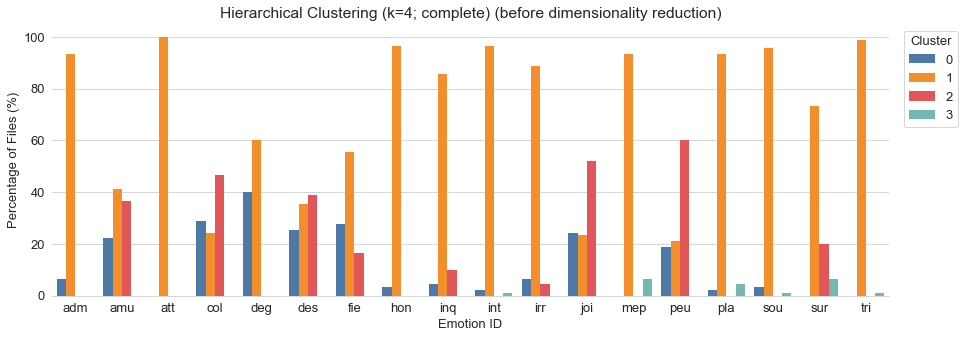

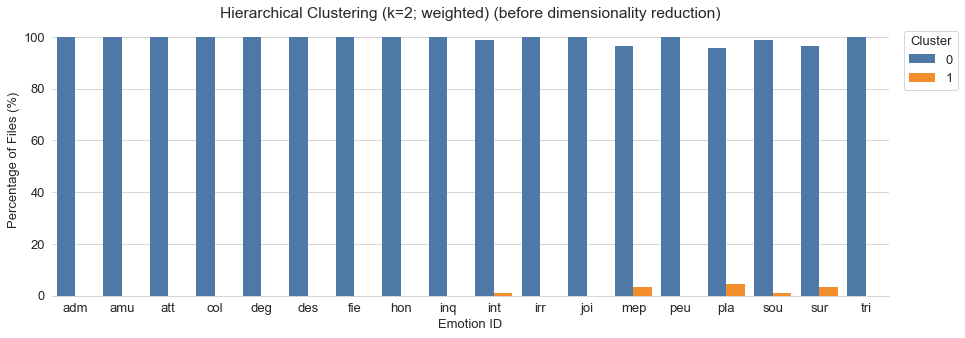

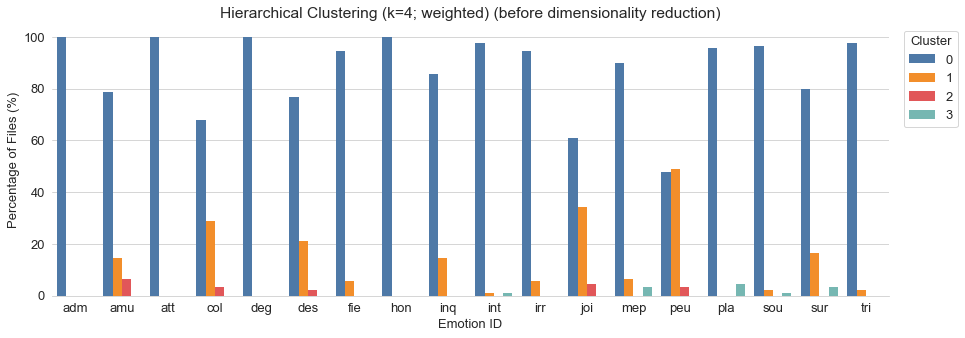

In [32]:
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree
tmp_df = multi_df.copy()
X_df = multi_df.drop(columns=['emotion_id'])


n_clusters_values = [2,4]
distance_method_values = ['single', 'complete', 'weighted']


for method in distance_method_values:

    links = linkage(X_df, method=method, metric='cityblock')
    clusters = cut_tree(links, n_clusters=n_clusters_values)

    for n in range(0,len(n_clusters_values)):
    
        tmp_df['cluster_'+str(n_clusters_values[n])] = clusters[:,n]   
        emotion_cluster = tmp_df.groupby(['emotion_id','cluster_'+str(n_clusters_values[n])]).agg({'F0semitoneFrom27.5Hz_sma3nz_amean':'count'}).rename(columns={'F0semitoneFrom27.5Hz_sma3nz_amean':'counts'})
        perc_df = emotion_cluster.groupby(level=0).apply(lambda x: 100 * x / x.sum()).reset_index().rename(columns={'counts':'percentage'})

        plt.figure(figsize=(15, 5))
        sns.barplot(x='emotion_id', y='percentage', hue='cluster_'+str(n_clusters_values[n]), data=perc_df, saturation=sns_saturation, palette=palette_def)
        plt.xlabel('Emotion ID')
        plt.ylabel('Percentage of Files (%)')
        plt.legend(title='Cluster', loc=1, bbox_to_anchor=(1.09, 1))
        plt.savefig(os.path.join(output_path,'charts','report_hier_clust_k_'+str(n_clusters_values[n])+'_'+method+'_before_dim_red.svg'), bbox_inches = 'tight')
        plt.title('Hierarchical Clustering (k='+str(n_clusters_values[n])+'; '+method+') (before dimensionality reduction)')
        plt.savefig(os.path.join(output_path,'charts','hier_clust_k_'+str(n_clusters_values[n])+'_'+method+'_before_dim_red.svg'), bbox_inches = 'tight')